In [1]:
#This project aims to explore the data from https://www.kaggle.com/c/liberty-mutual-group-property-inspection-prediction/
#This project will use models in sklearn with some outside libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_train = pd.read_csv('train.csv', index_col=0)
df_test = pd.read_csv('test.csv', index_col=0)

df_train.head()

,Hazard,T1_V1,T1_V2,T1_V3,T1_V4,T1_V5,T1_V6,T1_V7,T1_V8,T1_V9,...,T2_V6,T2_V7,T2_V8,T2_V9,T2_V10,T2_V11,T2_V12,T2_V13,T2_V14,T2_V15
Id,,,,,,,,,,,,,,,,,,,,,
1,1,15,3,2,N,B,N,B,B,D,...,2,37,1,11,6,Y,N,E,2,2
2,4,16,14,5,H,B,N,B,B,C,...,2,22,1,18,5,Y,Y,E,2,1
3,1,10,10,5,N,K,N,B,B,E,...,6,37,2,14,6,Y,Y,E,6,1
4,1,18,18,5,N,K,N,B,B,E,...,2,25,1,1,6,Y,N,C,2,6
5,1,13,19,5,N,H,N,B,B,E,...,1,22,1,2,7,N,N,E,1,1


In [3]:
#Categorical data needs to be transformed; converted to Ordinal. This will allow PCA to be used.
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for text in df_train.select_dtypes(exclude=np.number):
    df_train[text] = le.fit_transform(df_train[text])
    
for text in df_test.select_dtypes(exclude=np.number):
    df_test[text] = le.fit_transform(df_test[text])

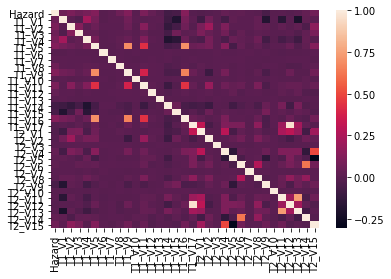

In [4]:
#Check to see if any variables are correlated with Hazard or strongly with each other
corr = df_train.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

labels = df_train.Hazard
df_train_it = df_train.copy()
df_train.drop('Hazard', axis=1, inplace=True)

In [5]:
#Highlight the strongest correlations, consider pca or grouping varaibles
corr = corr.mask(np.tril(np.ones(corr.shape)).astype(np.bool))
s = corr.unstack()
sorted_d = s.sort_values(ascending = False)
sorted_u = s.sort_values(ascending = True)
print(sorted_d[:10])
print(sorted_u[:10])

T2_V12  T1_V17    0.966422
T2_V13  T2_V11    0.735864
T1_V16  T1_V5     0.703725
T1_V9   T1_V5     0.690996
T1_V16  T1_V9     0.663679
T2_V14  T2_V6     0.624438
T2_V15  T2_V4     0.500179
T1_V16  T1_V11    0.436720
T1_V11  T1_V5     0.425989
        T1_V9     0.378861
dtype: float64
T2_V15  T2_V5   -0.304311
T2_V13  T1_V1   -0.209000
T1_V14  T1_V4   -0.189080
T1_V15  T1_V1   -0.184580
T2_V9   T1_V1   -0.178620
T2_V11  T1_V1   -0.156678
T1_V15  T1_V4   -0.151637
T2_V5   T2_V4   -0.146330
T2_V9   T2_V5   -0.140599
T2_V14  T2_V4   -0.131920
dtype: float64


In [6]:
from sklearn.decomposition import PCA

n_components=32
pca = PCA(n_components)
principalComponents = pca.fit_transform(df_train)

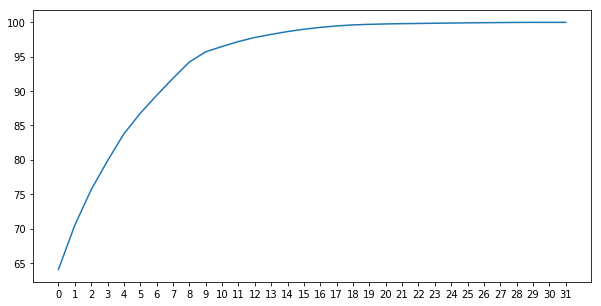

In [7]:
var= pca.explained_variance_ratio_

#Plot the cumulative variance amounts to find the optimal number of components
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

plt.figure(figsize=(10,5))
plt.plot(var1)
plt.xticks(range(32))
plt.show()

In [8]:
n_components=18
pca = PCA(n_components)
principalComponents = pca.fit_transform(df_train)
test_pca = pca.transform(df_test)
principalDf = pd.DataFrame(data = principalComponents
                           , columns = ['principal component ' + str(x+1) for x in range(n_components)])

In [9]:
#Indexes in the imported data set are not sequential and need to be reset
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(principalDf, df_train_it['Hazard'], test_size=0.3, random_state=0)

In [11]:
# 0x0FFF's Normalized Gini Scorer from Kaggle

from sklearn import metrics

def gini(solution, submission):
    df = zip(solution, submission, range(len(solution)))
    df = sorted(df, key=lambda x: (x[1],-x[2]), reverse=True)
    rand = [float(i+1)/float(len(df)) for i in range(len(df))]
    totalPos = float(sum([x[0] for x in df]))
    cumPosFound = [df[0][0]]
    for i in range(1,len(df)):
        cumPosFound.append(cumPosFound[len(cumPosFound)-1] + df[i][0])
    Lorentz = [float(x)/totalPos for x in cumPosFound]
    Gini = [Lorentz[i]-rand[i] for i in range(len(df))]
    return sum(Gini)

def normalized_gini(solution, submission):
    normalized_gini = gini(solution, submission)/gini(solution, solution)
    return normalized_gini

gini_scorer = metrics.make_scorer(normalized_gini, greater_is_better = True)

In [12]:
#Top score was 0.397064

from sklearn.linear_model import LinearRegression

clf = LinearRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

#Normalized Gini is the evaluation metric
print('Normalized Gini:', normalized_gini(y_test, y_pred)) 

Normalized Gini: 0.253509974899173


In [13]:
#Few features due to pca so ElasticNet and Lasso will work best
from sklearn.linear_model import ElasticNetCV, LassoCV

for model in (ElasticNetCV, LassoCV):
    iterm = model(cv=5, random_state=0)
    iterm.fit(X_train, y_train)
    y_pred = iterm.predict(X_test)
    print('Normalized Gini:', normalized_gini(y_test, y_pred)) 

Normalized Gini: 0.2535939017929964
Normalized Gini: 0.2535752384363594


In [14]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

for model in (RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor):
    clf = model()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Normalized Gini:', normalized_gini(y_test, y_pred))

Normalized Gini: 0.16267567337809463
Normalized Gini: 0.170599831013336
Normalized Gini: 0.27275831671837103


In [15]:
#Tune the hyperparameters for the best performing model
#Baysian optimization will generally outperform random search
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

reg = GradientBoostingRegressor()

n_features = X_train.shape[1]

space  = [Integer(1, 5, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

"Best score=%.4f" % res_gp.fun

'Best score=2.7881'

In [16]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4]))

#Best score yet
'''Best parameters:
- max_depth=4
- learning_rate=0.101495
- max_features=18
- min_samples_split=100
- min_samples_leaf=100'''

Best parameters:
- max_depth=4
- learning_rate=0.101495
- max_features=18
- min_samples_split=100
- min_samples_leaf=100


'Best parameters:\n- max_depth=3\n- learning_rate=0.142938\n- max_features=18\n- min_samples_split=100\n- min_samples_leaf=100'

In [17]:
modelp = GradientBoostingRegressor(max_depth=4, learning_rate=0.101495, max_features=18, min_samples_split=100, min_samples_leaf=100)
modelp.fit(X_train, y_train)
y_pred = modelp.predict(X_test)
print('Normalized Gini:', normalized_gini(y_test, y_pred))

Normalized Gini: 0.2867993894915145


In [18]:
#With a score of 0.2867993894915145 there likely isn't much more optimization that can be done with this model
#To get a higher score different methods can be used
#Since the dataset contains mixed data it would be best to use Factor Analysis of Mixed Data instead of just PCA
#Also, more advanced models can be used such as XGBoost or Neural Networks